In [1]:
# -*- coding: utf-8 -*-
import gc
import logging
from abc import abstractmethod
from copy import deepcopy
from typing import Dict, List, Literal, Optional, Tuple, Union, cast

import lightning as L
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.utils.hooks
from accelerate import init_empty_weights
from torch import Tensor, nn
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, LlamaForCausalLM
from typing_extensions import override

from fusion_bench.method import BaseModelFusionAlgorithm
from fusion_bench.method.pruning.prune_utils import (
    PruningType,
    compute_sparsity,
    find_linear_layers,
    semistructured_magnitude_prune_,
    unstructured_magnitude_prune_,
)
from fusion_bench.method.pruning.wanda_utils.data import get_loaders
from fusion_bench.method.pruning.wanda_utils.prune import prepare_calibration_input
from fusion_bench.mixins import SimpleProfilerMixin
from fusion_bench.modelpool import CausalLMPool
from fusion_bench.utils import cache_to_disk, print_parameters, timeit_context
from fusion_bench.utils.devices import get_device

# use times-new roman, no type 3 fonts
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams["font.family"] = "Times New Roman"
# math font
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
def load_model(model_path):
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
    )
    return model


def iterative_weight_update(W, S, mask, rank):
    L = W - S
    u, sigma, vh = torch.linalg.svd(L.float(), full_matrices=False)
    v = vh.t()
    rank = min(sigma.size(0) - 1, rank)
    uk = u[:, rank:]
    sk = sigma[rank:]
    vk = v[:, rank:]
    S = S + (mask * (uk @ torch.diag(sk) @ vk.t())).to(S.dtype)
    spectrum_ratio = torch.sum(sigma[:rank] * sigma[:rank]) / torch.sum(sigma * sigma)
    return (S, spectrum_ratio)


def pcp_loss_with_mask(w, q, mask):
    _lambda = 1 / np.sqrt(np.max(w.size()))
    nuclear_loss = torch.linalg.matrix_norm((w * (~mask) + q * mask).float(), ord="nuc")
    l1_loss = _lambda * torch.linalg.matrix_norm((w * mask - q * mask).float(), ord=1)
    return nuclear_loss + l1_loss


def PCP_search_with_mask(w, mask, T_max=1000, lr=1e-2):
    q = torch.zeros_like(w).float().requires_grad_(True)
    optimizer = torch.optim.AdamW([q], lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=T_max, eta_min=1e-1 * lr
    )
    for step_idx in tqdm(range(T_max)):
        optimizer.zero_grad()
        loss = pcp_loss_with_mask(w, q, mask)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        if step_idx % (T_max // 20) == 0:
            print(f"Step {step_idx}: Loss {loss.item()}")
    s = w * mask - q * mask
    return s

In [4]:
model = load_model(
    "/data0/users/tanganke/data/huggingface_models/decapoda-research/llama-7b-hf"
)
model.requires_grad_(False)

/data0/users/tanganke/anaconda3/envs/fusionbench/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:546: UserWarning: `pad_token_id` should be positive but got -1. This will cause errors when batch generating, if there is padding. Please set `pad_token_id` explicitly by `model.generation_config.pad_token_id=PAD_TOKEN_ID` to avoid errors in generation, and ensure your `input_ids` input does not have negative values.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=31999)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-06)
  

In [4]:
linear = deepcopy(model.model.layers[0].self_attn.q_proj).to("cuda:7")
# linear.weight.data = torch.rand_like(linear.weight.data)
W = linear.weight[:512, :512].clone()
S = unstructured_magnitude_prune_(
    W.clone(),
    metric_function_or_scores=torch.abs,
    sparsity_ratio=0.5,
)
mask: Tensor = S != 0

In [15]:
# Baseline 1: update weights with PCP
pcp_s = PCP_search_with_mask(W, mask, T_max=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

Step 0: Loss 44.41257858276367
Step 250: Loss 42.71278762817383
Step 500: Loss 42.70803451538086
Step 750: Loss 42.613487243652344
Step 1000: Loss 42.47605514526367
Step 1250: Loss 42.291507720947266
Step 1500: Loss 42.101619720458984
Step 1750: Loss 41.877281188964844
Step 2000: Loss 41.66060256958008
Step 2250: Loss 41.422828674316406
Step 2500: Loss 41.156917572021484
Step 2750: Loss 40.93293380737305
Step 3000: Loss 40.698699951171875
Step 3250: Loss 40.4942626953125
Step 3500: Loss 40.29460144042969
Step 3750: Loss 40.121707916259766
Step 4000: Loss 39.972896575927734
Step 4250: Loss 39.85190200805664
Step 4500: Loss 39.76426315307617
Step 4750: Loss 39.71201705932617


In [57]:
s_t = S.clone()
for step_idx, rank in tqdm(enumerate(np.linspace(2, 64, 50, dtype=np.int64))):
    s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask.float(), rank=rank)
    if spectrum_ratio > 0.99:
        break
ours_s_64 = s_t

s_t = S.clone()
for step_idx, rank in tqdm(enumerate(np.linspace(2, 128, 50, dtype=np.int64))):
    s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask.float(), rank=rank)
    if spectrum_ratio > 0.99:
        break
ours_s_128 = s_t

s_t = S.clone()
for step_idx, rank in tqdm(enumerate(np.linspace(2, 512, 50, dtype=np.int64))):
    s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask, rank=rank)
    if spectrum_ratio > 0.99:
        pass
        # break
ours_s_512 = s_t

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [7]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


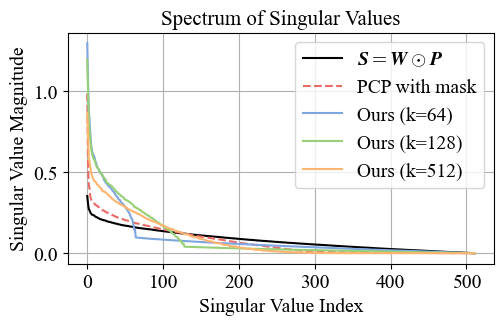

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


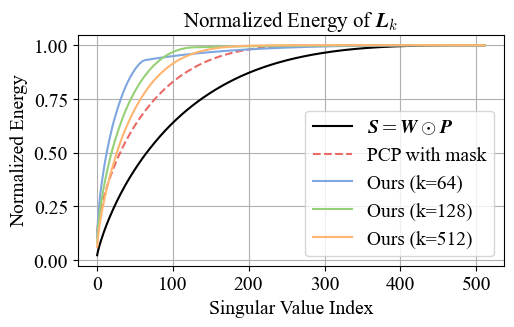

In [71]:
def cumsum_svd(s):
    return torch.cumsum(s * s, dim=0) / torch.sum(s * s)


colors = [
    "#EA6B66",
    "#7EA6E0",
    "#97D077",
    "#FFB570",
    "#FF99FF",
    "#CCCC00",
    "#000099",
    "#666666",
    "#CCCCCC",
]

# set font size to 16
plt.rcParams.update({"font.size": 14})
# set the font size of title to 16
plt.rcParams.update({"axes.titlesize": 15})

with torch.no_grad():
    # Assuming singular_values is your dictionary with step_idx as keys and s (numpy arrays) as values
    plt.figure(figsize=(5.5, 3))

    plt.plot(
        torch.linalg.svdvals(W.float() * (~mask)).detach().cpu().numpy(),
        label=R"$\boldsymbol{S} =\boldsymbol{W} \odot \boldsymbol{P}$",
        # dashed black line
        color="black",
    )
    plt.plot(
        torch.linalg.svdvals(W - pcp_s).detach().cpu().numpy(),
        label="PCP with mask",
        color=colors[0],
        linestyle="--",
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_64.float()).detach().cpu().numpy(),
        label="Ours (k=64)",
        color=colors[1],
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_128.float()).detach().cpu().numpy(),
        label="Ours (k=128)",
        color=colors[2],
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_512.float()).detach().cpu().numpy(),
        label="Ours (k=512)",
        color=colors[3],
    )

    plt.xlabel("Singular Value Index")

    plt.ylabel("Singular Value Magnitude")
    plt.title("Spectrum of Singular Values")
    plt.legend()
    # plt.yscale("log")  # Use log scale for y-axis to better visualize the spectrum
    plt.grid(True)

    plt.savefig("spectrum.pdf", bbox_inches="tight")
    plt.show()

    # Assuming singular_values is your dictionary with step_idx as keys and s (numpy arrays) as values
    plt.figure(figsize=(5.5, 3))

    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W.float() * ~mask).detach()).cpu().numpy(),
        label=R"$\boldsymbol{S} =\boldsymbol{W} \odot \boldsymbol{P}$",
        # dashed black line
        # linestyle="--",
        color="black",
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - pcp_s).detach()).cpu().numpy(),
        label="PCP with mask",
        color=colors[0],
        linestyle="--",
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - ours_s_64.float()).detach()).cpu().numpy(),
        label="Ours (k=64)",
        color=colors[1],
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - ours_s_128.float()).detach()).cpu().numpy(),
        label="Ours (k=128)",
        color=colors[2],
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - ours_s_512.float()).detach()).cpu().numpy(),
        label="Ours (k=512)",
        color=colors[3],
    )

    plt.xlabel("Singular Value Index")

    plt.ylabel("Normalized Energy")
    plt.title(R"Normalized Energy of $\boldsymbol{L}_k$")
    plt.legend()
    # plt.yscale("log")  # Use log scale for y-axis to better visualize the spectrum
    plt.grid(True)

    plt.savefig("energy.pdf", bbox_inches="tight")
    plt.show()

## Algorithm Analysis

In [5]:
linear = deepcopy(model.model.layers[0].self_attn.q_proj).to("cuda:4")
# linear.weight.data = torch.rand_like(linear.weight.data)
W = linear.weight.clone()
S = unstructured_magnitude_prune_(
    W.clone(),
    metric_function_or_scores=torch.abs,
    sparsity_ratio=0.5,
)
mask: Tensor = S != 0

In [7]:
pcp_s = PCP_search_with_mask(W, mask, T_max=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Step 0: Loss 1520.411865234375
Step 5: Loss 1723.2286376953125
Step 10: Loss 1547.4130859375
Step 15: Loss 1488.4818115234375
Step 20: Loss 1447.9324951171875
Step 25: Loss 1423.41357421875
Step 30: Loss 1407.1278076171875
Step 35: Loss 1395.8187255859375
Step 40: Loss 1387.1905517578125
Step 45: Loss 1380.0986328125
Step 50: Loss 1373.8900146484375
Step 55: Loss 1368.1787109375
Step 60: Loss 1362.9515380859375
Step 65: Loss 1357.9344482421875
Step 70: Loss 1353.419677734375
Step 75: Loss 1349.283203125
Step 80: Loss 1345.74755859375
Step 85: Loss 1342.7342529296875
Step 90: Loss 1340.1978759765625
Step 95: Loss 1338.445068359375


In [8]:
s_t = S.clone()
for step_idx, rank in tqdm(enumerate(np.linspace(2, 64, 50, dtype=np.int64))):
    s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask.float(), rank=rank)
    if spectrum_ratio > 0.99:
        break
ours_s_64 = s_t

s_t = S.clone()
for step_idx, rank in tqdm(enumerate(np.linspace(2, 128, 50, dtype=np.int64))):
    s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask.float(), rank=rank)
    if spectrum_ratio > 0.99:
        break
ours_s_128 = s_t

s_t = S.clone()
outs_s_512_at_steps = {}
for step_idx, rank in tqdm(enumerate(np.linspace(1, 512, 50, dtype=np.int64))):
    s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask, rank=rank)
    if spectrum_ratio > 0.99:
        pass
        # break
    if (step_idx + 1) % 10 == 0:
        outs_s_512_at_steps[step_idx + 1] = s_t.clone()
ours_s_512 = s_t

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


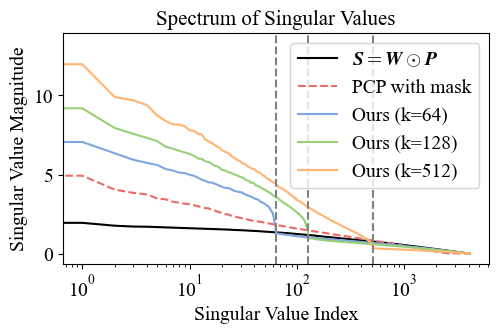

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


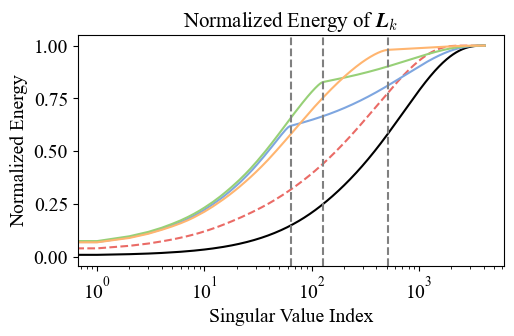

In [26]:
def cumsum_svd(s):
    return torch.cumsum(s * s, dim=0) / torch.sum(s * s)


colors = [
    "#EA6B66",
    "#7EA6E0",
    "#97D077",
    "#FFB570",
    "#FF99FF",
    "#CCCC00",
    "#000099",
    "#666666",
    "#CCCCCC",
]

# set font size to 16
plt.rcParams.update({"font.size": 14})
# set the font size of title to 16
plt.rcParams.update({"axes.titlesize": 15})

with torch.no_grad():
    # Assuming singular_values is your dictionary with step_idx as keys and s (numpy arrays) as values
    plt.figure(figsize=(5.5, 3))

    plt.plot(
        torch.linalg.svdvals(W.float() * (~mask)).detach().cpu().numpy(),
        label=R"$\boldsymbol{S} =\boldsymbol{W} \odot \boldsymbol{P}$",
        # dashed black line
        color="black",
    )
    plt.plot(
        torch.linalg.svdvals(W - pcp_s).detach().cpu().numpy(),
        label="PCP with mask",
        color=colors[0],
        linestyle="--",
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_64.float()).detach().cpu().numpy(),
        label="Ours (k=64)",
        color=colors[1],
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_128.float()).detach().cpu().numpy(),
        label="Ours (k=128)",
        color=colors[2],
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_512.float()).detach().cpu().numpy(),
        label="Ours (k=512)",
        color=colors[3],
    )

    plt.xlabel("Singular Value Index")

    plt.ylabel("Singular Value Magnitude")
    plt.title("Spectrum of Singular Values")
    plt.legend()
    plt.xscale("log")  # Use log scale for y-axis to better visualize the spectrum
    # plt.grid(True)
    # instead of plot grid, plot x = 64, x=128 and x=512
    plt.axvline(x=64, color="gray", linestyle="--")
    plt.axvline(x=128, color="gray", linestyle="--")
    plt.axvline(x=512, color="gray", linestyle="--")

    plt.savefig("spectrum.pdf", bbox_inches="tight")
    plt.show()

    # Assuming singular_values is your dictionary with step_idx as keys and s (numpy arrays) as values
    plt.figure(figsize=(5.5, 3))

    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W.float() * ~mask).detach()).cpu().numpy(),
        label=R"$\boldsymbol{S} =\boldsymbol{W} \odot \boldsymbol{P}$",
        # dashed black line
        # linestyle="--",
        color="black",
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - pcp_s).detach()).cpu().numpy(),
        label="PCP with mask",
        color=colors[0],
        linestyle="--",
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - ours_s_64.float()).detach()).cpu().numpy(),
        label="Ours (k=64)",
        color=colors[1],
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - ours_s_128.float()).detach()).cpu().numpy(),
        label="Ours (k=128)",
        color=colors[2],
    )
    plt.plot(
        cumsum_svd(torch.linalg.svdvals(W - ours_s_512.float()).detach()).cpu().numpy(),
        label="Ours (k=512)",
        color=colors[3],
    )

    plt.xlabel("Singular Value Index")

    plt.ylabel("Normalized Energy")
    plt.title(R"Normalized Energy of $\boldsymbol{L}_k$")
    # plt.legend()
    plt.xscale("log")  # Use log scale for y-axis to better visualize the spectrum
    # plt.grid(True)
    plt.axvline(x=64, color="gray", linestyle="--")
    plt.axvline(x=128, color="gray", linestyle="--")
    plt.axvline(x=512, color="gray", linestyle="--")

    plt.savefig("energy.pdf", bbox_inches="tight")
    plt.show()

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


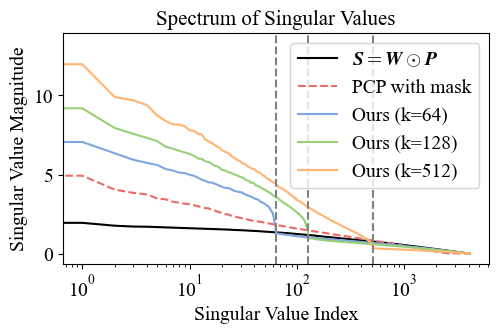

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


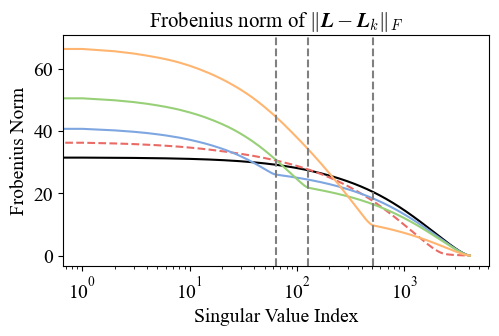

In [27]:
def cumsum_svd_from_k(s):
    s_square = s * s
    # the i-th value: \sum_{j=i}^{len(s)} s[j]^2
    return torch.sqrt(torch.sum(s_square) - torch.cumsum(s_square, dim=0))


colors = [
    "#EA6B66",
    "#7EA6E0",
    "#97D077",
    "#FFB570",
    "#FF99FF",
    "#CCCC00",
    "#000099",
    "#666666",
    "#CCCCCC",
]

# set font size to 16
plt.rcParams.update({"font.size": 14})
# set the font size of title to 16
plt.rcParams.update({"axes.titlesize": 15})

with torch.no_grad():
    # Assuming singular_values is your dictionary with step_idx as keys and s (numpy arrays) as values
    plt.figure(figsize=(5.5, 3))

    plt.plot(
        torch.linalg.svdvals(W.float() * (~mask)).detach().cpu().numpy(),
        label=R"$\boldsymbol{S} =\boldsymbol{W} \odot \boldsymbol{P}$",
        # dashed black line
        color="black",
    )
    plt.plot(
        torch.linalg.svdvals(W - pcp_s).detach().cpu().numpy(),
        label="PCP with mask",
        color=colors[0],
        linestyle="--",
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_64.float()).detach().cpu().numpy(),
        label="Ours (k=64)",
        color=colors[1],
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_128.float()).detach().cpu().numpy(),
        label="Ours (k=128)",
        color=colors[2],
    )
    plt.plot(
        torch.linalg.svdvals(W - ours_s_512.float()).detach().cpu().numpy(),
        label="Ours (k=512)",
        color=colors[3],
    )

    plt.xlabel("Singular Value Index")

    plt.ylabel("Singular Value Magnitude")
    plt.title("Spectrum of Singular Values")
    plt.legend()
    plt.xscale("log")  # Use log scale for y-axis to better visualize the spectrum
    # plt.grid(True)
    # instead of plot grid, plot x = 64, x=128 and x=512
    plt.axvline(x=64, color="gray", linestyle="--")
    plt.axvline(x=128, color="gray", linestyle="--")
    plt.axvline(x=512, color="gray", linestyle="--")

    plt.savefig("spectrum.pdf", bbox_inches="tight")
    plt.show()

    # Assuming singular_values is your dictionary with step_idx as keys and s (numpy arrays) as values
    plt.figure(figsize=(5.5, 3))

    plt.plot(
        cumsum_svd_from_k(torch.linalg.svdvals(W.float() * ~mask).detach())
        .cpu()
        .numpy(),
        label=R"$\boldsymbol{S} =\boldsymbol{W} \odot \boldsymbol{P}$",
        # dashed black line
        # linestyle="--",
        color="black",
    )
    plt.plot(
        cumsum_svd_from_k(torch.linalg.svdvals(W - pcp_s).detach()).cpu().numpy(),
        label="PCP with mask",
        color=colors[0],
        linestyle="--",
    )
    plt.plot(
        cumsum_svd_from_k(torch.linalg.svdvals(W - ours_s_64.float()).detach())
        .cpu()
        .numpy(),
        label="Ours (k=64)",
        color=colors[1],
    )
    plt.plot(
        cumsum_svd_from_k(torch.linalg.svdvals(W - ours_s_128.float()).detach())
        .cpu()
        .numpy(),
        label="Ours (k=128)",
        color=colors[2],
    )
    plt.plot(
        cumsum_svd_from_k(torch.linalg.svdvals(W - ours_s_512.float()).detach())
        .cpu()
        .numpy(),
        label="Ours (k=512)",
        color=colors[3],
    )

    plt.xlabel("Singular Value Index")

    plt.ylabel("Frobenius Norm")
    plt.title(R"Frobenius norm of $\|\boldsymbol{L} - \boldsymbol{L}_k\|_F$")
    # plt.legend()
    plt.xscale("log")  # Use log scale for y-axis to better visualize the spectrum
    # plt.yscale("log")
    # plt.grid(True)
    plt.axvline(x=64, color="gray", linestyle="--")
    plt.axvline(x=128, color="gray", linestyle="--")
    plt.axvline(x=512, color="gray", linestyle="--")

    plt.savefig("frobnius.pdf", bbox_inches="tight")
    plt.show()

In [28]:
s_t = S.clone()
outs_s_512_at_steps = {}
for step_idx, rank in tqdm(enumerate(np.linspace(1, 512, 50, dtype=np.int64))):
    s_t, spectrum_ratio = iterative_weight_update(W, s_t, mask, rank=rank)
    if spectrum_ratio > 0.99:
        pass
        # break
    if (step_idx + 1) % 10 == 0:
        outs_s_512_at_steps[step_idx + 1] = s_t.clone()
ours_s_512 = s_t

0it [00:00, ?it/s]

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


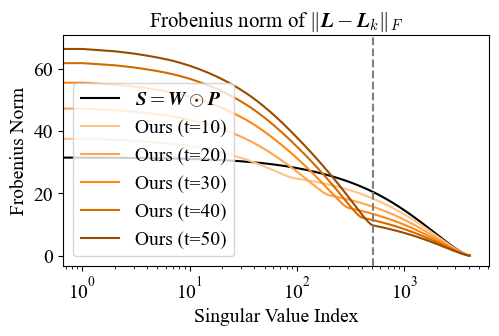

In [38]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


with torch.no_grad():
    plt.figure(figsize=(5.5, 3))

    plt.plot(
        cumsum_svd_from_k(torch.linalg.svdvals(W.float() * ~mask).detach())
        .cpu()
        .numpy(),
        label=R"$\boldsymbol{S} =\boldsymbol{W} \odot \boldsymbol{P}$",
        # dashed black line
        # linestyle="--",
        color="black",
    )
    for color_idx, step_idx in enumerate([10, 20, 30, 40, 50]):
        plt.plot(
            cumsum_svd_from_k(
                torch.linalg.svdvals(
                    (W - outs_s_512_at_steps[step_idx]).float()
                ).detach()
            )
            .cpu()
            .numpy(),
            label=f"Ours (t={step_idx})",
            color=lighten_color("#994C00", (color_idx + 2) / 6),
        )

    plt.xlabel("Singular Value Index")

    plt.ylabel("Frobenius Norm")
    plt.title(R"Frobenius norm of $\|\boldsymbol{L} - \boldsymbol{L}_k\|_F$")
    plt.legend()
    plt.xscale("log")  # Use log scale for y-axis to better visualize the spectrum
    # plt.yscale("log")
    # plt.grid(True)
    plt.axvline(x=512, color="gray", linestyle="--")

    plt.savefig("frobnius.pdf", bbox_inches="tight")
    plt.show()